In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv("tatasteel_stock.csv")

In [9]:
df.head()

,Date,Price,High,Low,Open,Volume
0,1996-01-01,8.987900,9.010454,8.866107,8.976623,10242229
1,1996-01-02,8.820998,9.010455,8.798444,8.976624,16954313
2,1996-01-03,8.823254,9.021732,8.798444,8.820998,13514114
3,1996-01-04,8.543581,8.683418,8.345102,8.683418,34785820
4,1996-01-05,8.374422,8.480427,8.288716,8.439831,30138033


In [10]:

df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df.asfreq(df.index.inferred_freq or 'B')

In [11]:
df[['Price']].isna().sum()

Price    292
dtype: int64

In [12]:
df = df[['Price']].dropna()

In [13]:
df

,Price
Date,
1996-01-01,8.987900
1996-01-02,8.820998
1996-01-03,8.823254
1996-01-04,8.543581
1996-01-05,8.374422
...,...
2025-06-20,151.970001
2025-06-23,152.429993
2025-06-24,154.789993


In [14]:
df.index=pd.DatetimeIndex(df.index)
df.index.freq=df.index.inferred_freq

In [18]:
train_size=int(len(df)*0.8)
train = df[:train_size]
test = df[train_size:]

In [19]:
train

,Price
Date,
1996-01-01,8.987900
1996-01-02,8.820998
1996-01-03,8.823254
1996-01-04,8.543581
1996-01-05,8.374422
...,...
2019-06-20,40.969284
2019-06-21,40.695343
2019-06-24,39.763107


In [20]:
auto_model=auto_arima(train,seasonal=False,stepwise=True,suppress_warnings=True)
p,d,q=auto_model.order
print(f"Best ARIMA order: (p={p}, d={d}, q={q})")
model=ARIMA(train,order=(p,d,q))
fitted_model=model.fit()

Best ARIMA order: (p=1, d=1, q=2)


In [22]:
forecast = fitted_model.forecast(steps=len(test))
forecast_series = pd.Series(forecast, index=test.index)

In [24]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 59.14
RMSE: 69.89


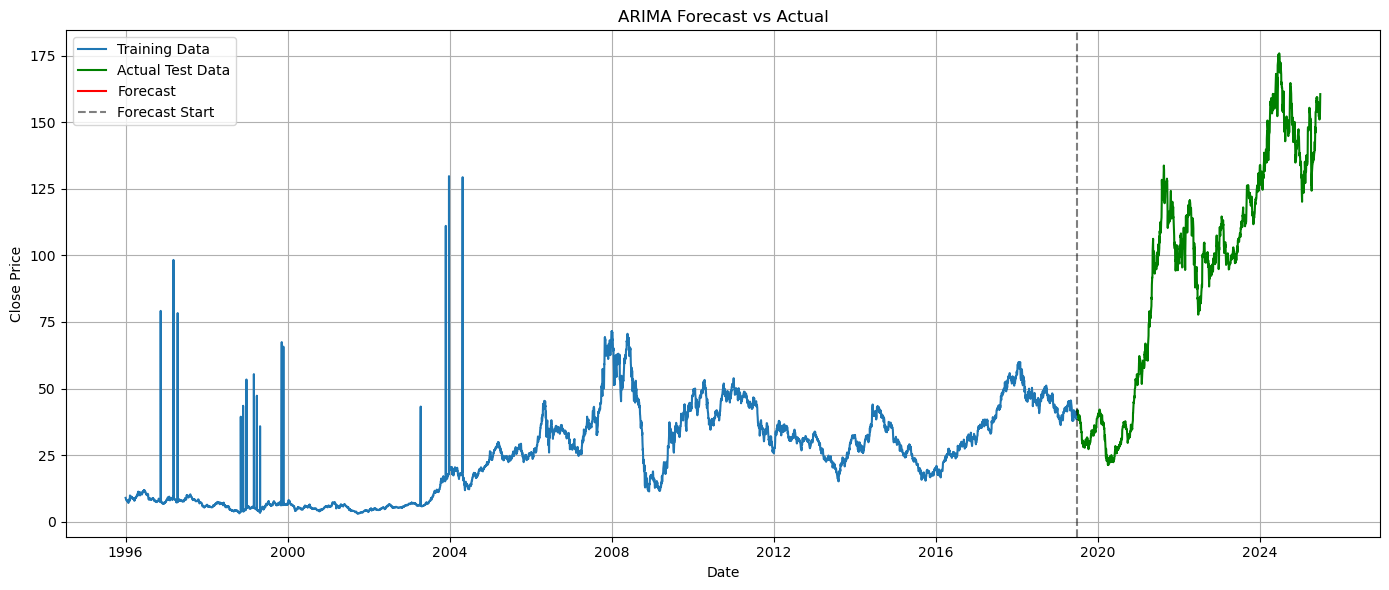

In [52]:
plt.figure(figsize=(14, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Test Data', color = "green")
plt.plot(forecast_series, label='Forecast', color='red')
plt.axvline(test.index[0], color='black', linestyle='--', alpha=0.5, label='Forecast Start')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
final_model=ARIMA(df,order=(p,d,q))
final_fit=final_model.fit()
future_steps=180

In [28]:
future_forecast=final_fit.get_forecast(steps=future_steps)
future_mean=future_forecast.predicted_mean
conf_int=future_forecast.conf_int()

In [29]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='B')

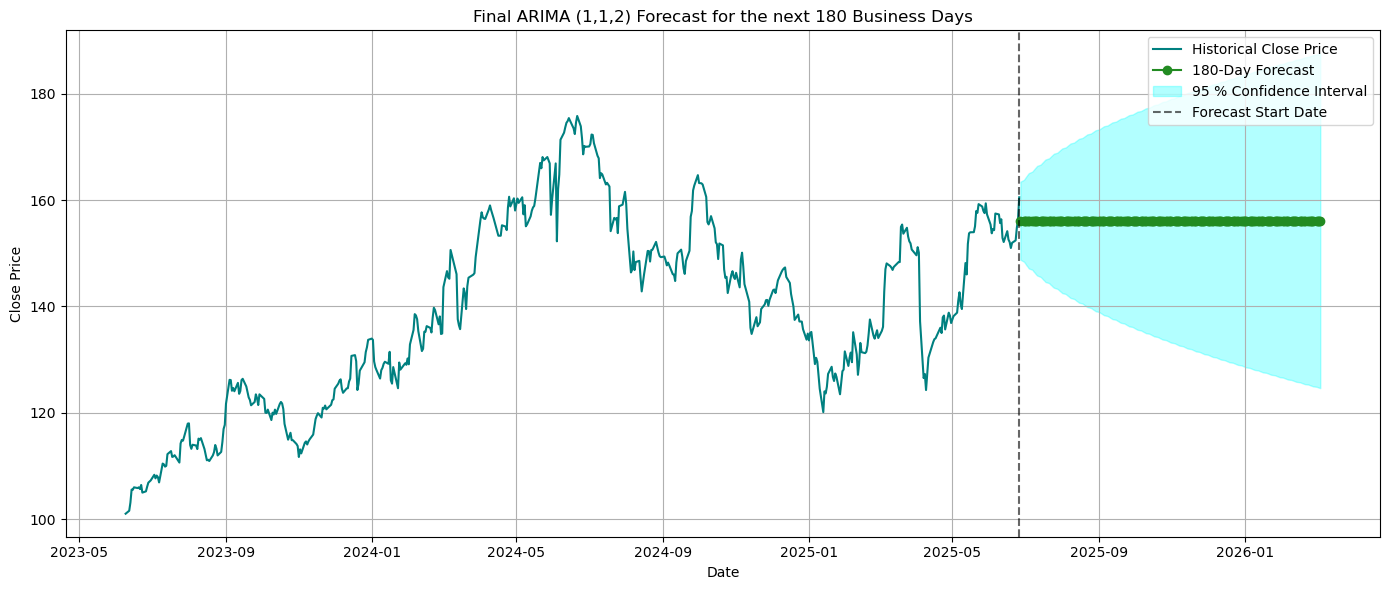

In [50]:
plt.figure(figsize=(14,6))
recent_data = df[df.index >= df.index[-252*2]]  # roughly last 2 years of business days
plt.plot(recent_data, label="Historical Close Price", color = "teal")
plt.plot(future_dates,future_mean,label='180-Day Forecast',color='forestgreen',marker='o',linestyle='solid')
plt.fill_between(future_dates,conf_int.iloc[:,0],conf_int.iloc[:,1],color='cyan',alpha=0.3,label='95 % Confidence Interval')
plt.axvline(x=last_date,color='black',linestyle='--',alpha=0.6,label='Forecast Start Date')
plt.title(f"Final ARIMA ({p},{d},{q}) Forecast for the next 180 Business Days")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()